# Online Payments Fraud Detection
-----

**Importing necessary libraries**

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings 
import pickle 

In [101]:
df_unbalanced = pd.read_csv(r"C:\Users\aarav\Downloads\PS_20174392719_1491204439457_log.csv")

In [102]:
df_unbalanced

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,C1179511630,479803.00,347245.65,C435674507,484329.37,616886.72,0
1048571,95,PAYMENT,9917.36,C1956161225,90545.00,80627.64,M668364942,0.00,0.00,0
1048572,95,PAYMENT,14140.05,C2037964975,20545.00,6404.95,M1355182933,0.00,0.00,0
1048573,95,PAYMENT,10020.05,C1633237354,90605.00,80584.95,M1964992463,0.00,0.00,0


In [103]:
df_unbalanced.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [104]:
df_unbalanced['step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64)

In [105]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
print(df_unbalanced['isFraud'].value_counts())

isFraud
0    1047433
1       1142
Name: count, dtype: int64


**The dataset is not balanced**

Balancing the dataset 

In [106]:
df_majority = df_unbalanced[df_unbalanced['isFraud'] == 0] # seperating farud and not_fraud 
df_minority = df_unbalanced[df_unbalanced['isFraud'] == 1]

df_majority_downsampled = df_majority.sample(n=1288, random_state=42) 

'''sample 1288 rows from the majority class to make the dataset similar 

to the project requirement'''


# Combine the downsampled majority with the minority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])


# Optionally shuffle the resulting DataFrame
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True) 


In [107]:
df # display final dataset with balanced classes

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,10,PAYMENT,20794.73,C815510261,116.00,0.00,M1382693228,0.00,0.00,0
1,60,CASH_OUT,45807.51,C981996349,45807.51,0.00,C1099066639,267824.05,313631.56,1
2,39,PAYMENT,8189.26,C1612875324,50853.00,42663.74,M1964286640,0.00,0.00,0
3,39,CASH_OUT,128892.25,C1711392639,0.00,0.00,C1767398596,206116.00,0.00,0
4,77,CASH_OUT,5715004.30,C1519833841,5715004.30,0.00,C1856760155,318309.23,6033313.53,1
...,...,...,...,...,...,...,...,...,...,...
2425,33,CASH_OUT,3295227.84,C1587398978,3295227.84,0.00,C1560573396,0.00,4002861.53,1
2426,45,CASH_IN,90016.84,C1739014367,21234.00,111250.84,C1947527507,1691662.88,1601646.04,0
2427,42,CASH_OUT,55963.20,C1284017456,10919.00,0.00,C2087603149,0.00,55963.20,0
2428,1,CASH_OUT,416001.33,C749981943,0.00,0.00,C667346055,102.00,9291619.62,1


In [108]:
df['isFraud'].value_counts() 

isFraud
0    1288
1    1142
Name: count, dtype: int64

In [109]:
df_numdata = df.select_dtypes(include='number')

correlation_matrix = df_numdata.corr()  # correlation matrix only takes numeric data, hence filtering non numeric values


In [110]:
correlation_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,0.238987,0.060930,-0.097938,-0.067304,0.000398,0.434458
amount,0.238987,1.000000,0.520731,-0.029674,-0.016854,0.289458,0.345850
oldbalanceOrg,0.060930,0.520731,1.000000,0.833966,0.073563,0.192289,0.051832
newbalanceOrig,-0.097938,-0.029674,0.833966,1.000000,0.115453,0.058419,-0.192257
oldbalanceDest,-0.067304,-0.016854,0.073563,0.115453,1.000000,0.884497,-0.129028
newbalanceDest,0.000398,0.289458,0.192289,0.058419,0.884497,1.000000,-0.010683
isFraud,0.434458,0.345850,0.051832,-0.192257,-0.129028,-0.010683,1.000000


<Axes: >

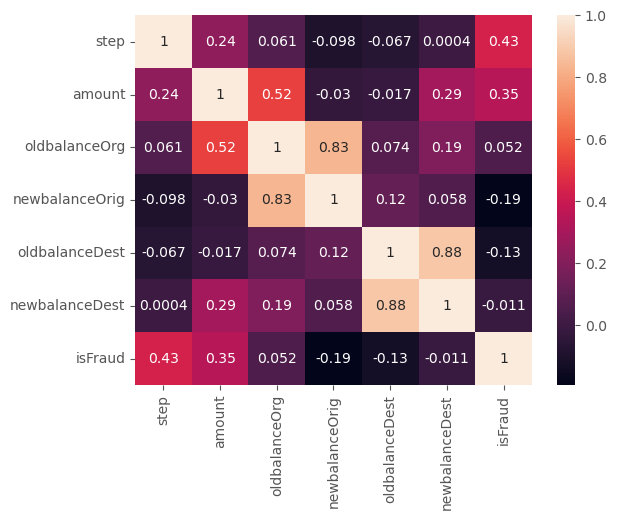

In [111]:
sns.heatmap(correlation_matrix, annot = True)

----------

**EDA**

nameDest
C681692677     2
C1013511446    2
C52390890      2
C1827219533    2
C1073409712    2
              ..
C750661006     1
M1973052189    1
C332249974     1
C825022387     1
C996035587     1
Name: count, Length: 2409, dtype: int64
isFraud
0    1288
1    1142
Name: count, dtype: int64


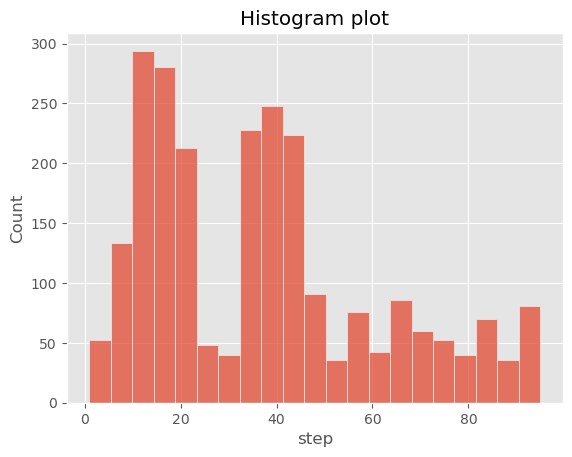

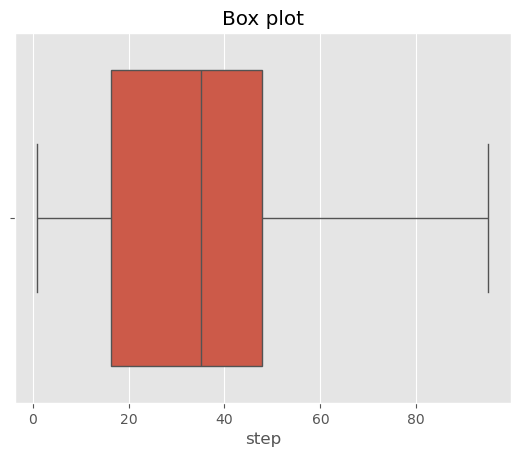

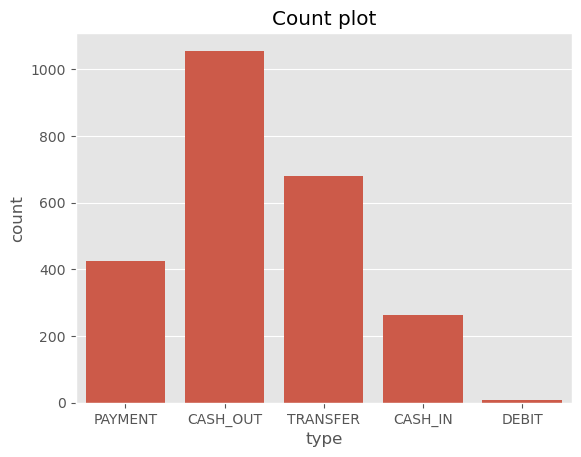

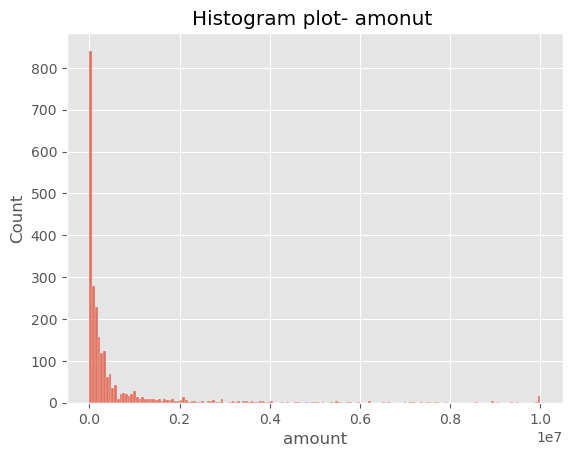

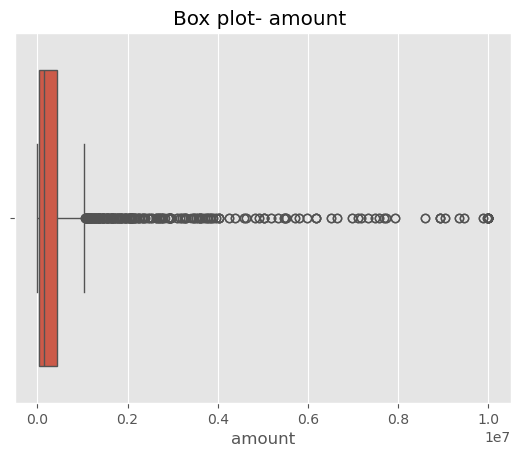

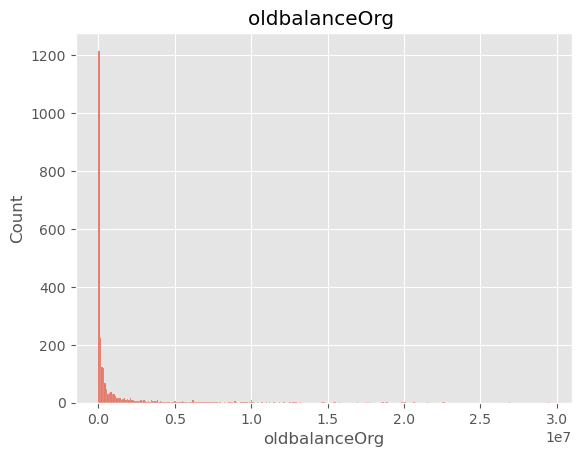

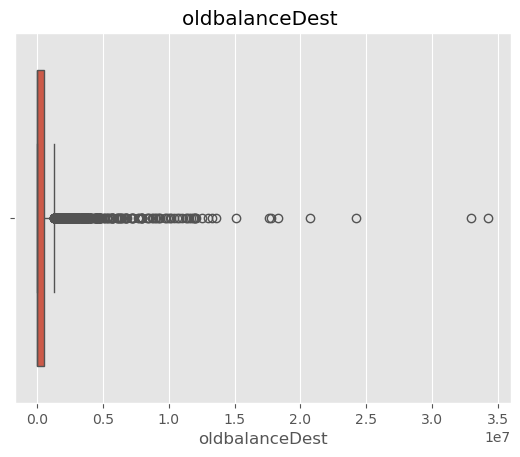

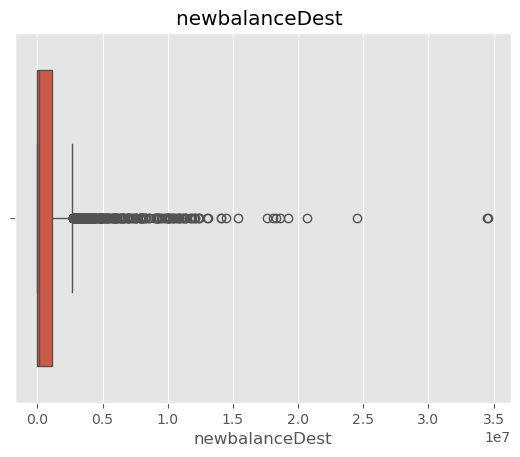

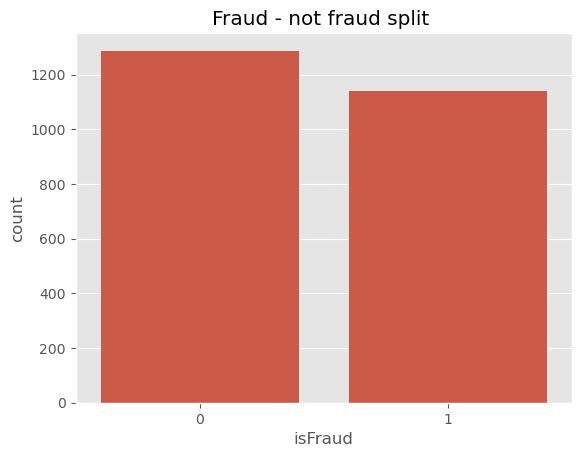

In [112]:
plt.figure(1)
plt.title("Histogram plot")
sns.histplot(data= df, x = 'step')

plt.figure(2)
plt.title("Box plot")
sns.boxplot(data= df, x = 'step')

plt.figure(3)
plt.title("Count plot")
sns.countplot(data= df, x = 'type')

plt.figure(4)
plt.title("Histogram plot- amonut ")
sns.histplot(data= df, x = 'amount')

plt.figure(5)
plt.title("Box plot- amount ")
sns.boxplot(data= df, x = 'amount')

plt.figure(6)
plt.title("oldbalanceOrg ")
sns.histplot(data= df, x = 'oldbalanceOrg')

plt.figure(7)
plt.title("oldbalanceDest ")
sns.boxplot(data= df, x = 'oldbalanceDest')

plt.figure(8)
plt.title("newbalanceDest ")
sns.boxplot(data= df, x = 'newbalanceDest')

plt.figure(9)
plt.title("Fraud - not fraud split ")
sns.countplot(data= df, x = 'isFraud')


print(df['nameDest'].value_counts())
print(df['isFraud'].value_counts())

In [113]:
df.loc[df['isFraud']==0,'isFraud']  = ' is not Fraud '
df.loc[df['isFraud']==1,'isFraud']  = '  Fraud '

In [114]:
df['isFraud']

0        is not Fraud 
1               Fraud 
2        is not Fraud 
3        is not Fraud 
4               Fraud 
             ...      
2425            Fraud 
2426     is not Fraud 
2427     is not Fraud 
2428            Fraud 
2429     is not Fraud 
Name: isFraud, Length: 2430, dtype: object

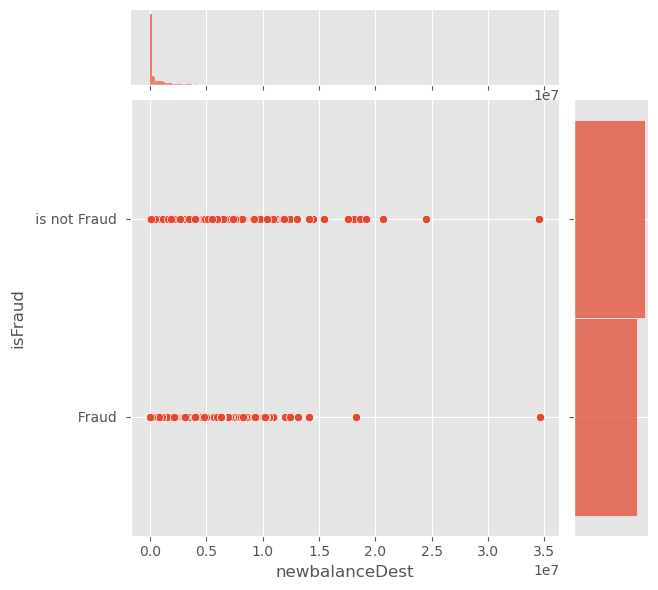

In [115]:
sns.jointplot(data = df, x="newbalanceDest", y = 'isFraud')

<Axes: xlabel='type', ylabel='count'>

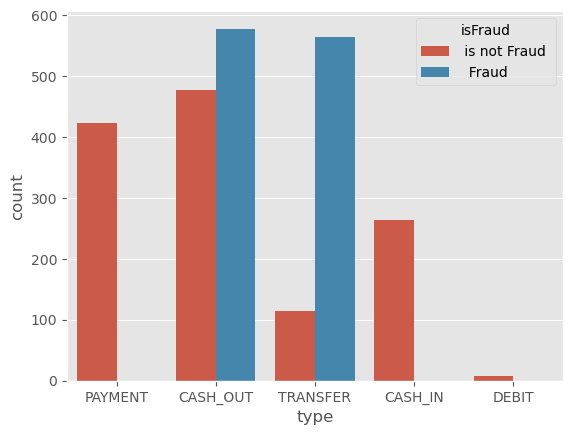

In [116]:
sns.countplot(data = df, x= 'type', hue = 'isFraud')

<Axes: xlabel='isFraud', ylabel='step'>

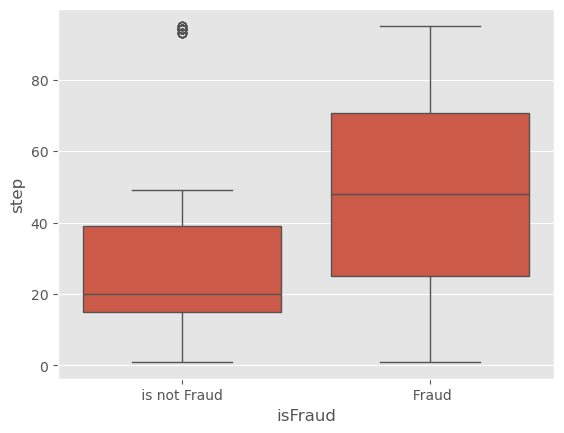

In [117]:
sns.boxplot(data = df, x='isFraud' , y = 'step')

<Axes: xlabel='isFraud', ylabel='amount'>

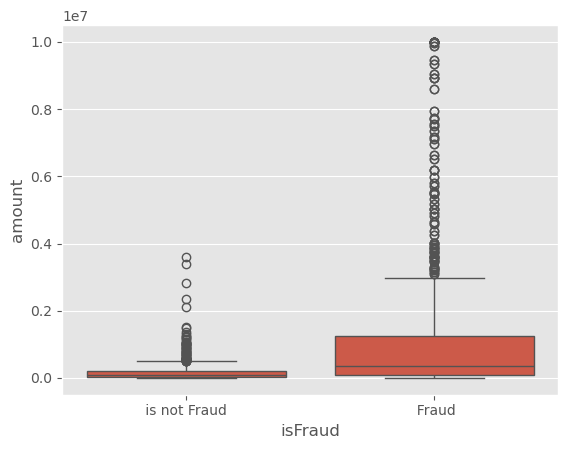

In [118]:
sns.boxplot(data = df, x='isFraud' , y = 'amount')

<Axes: xlabel='isFraud', ylabel='oldbalanceOrg'>

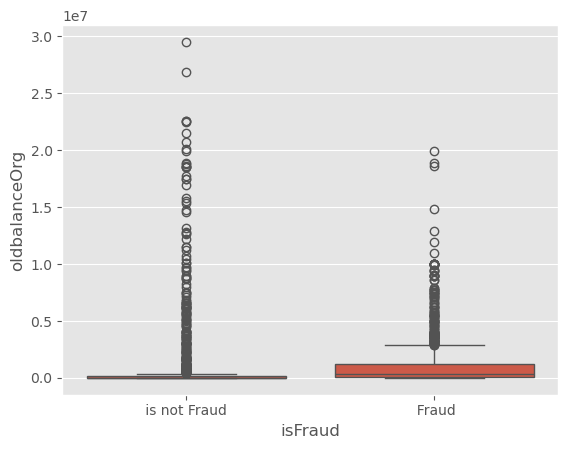

In [119]:
sns.boxplot(data = df, x='isFraud' , y = 'oldbalanceOrg')

<Axes: xlabel='isFraud', ylabel='newbalanceOrig'>

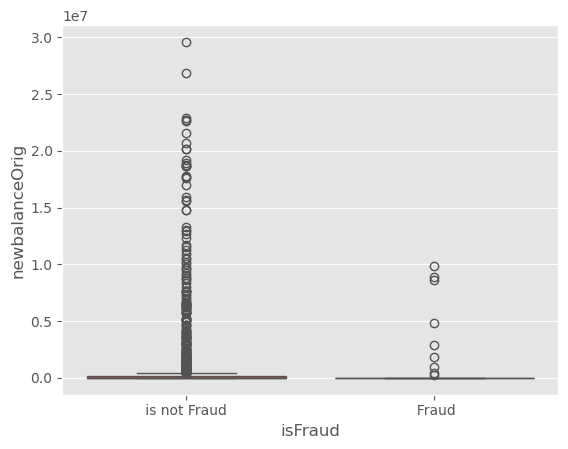

In [120]:
sns.boxplot(data = df, x='isFraud' , y = 'newbalanceOrig')

<Axes: xlabel='isFraud', ylabel='oldbalanceDest'>

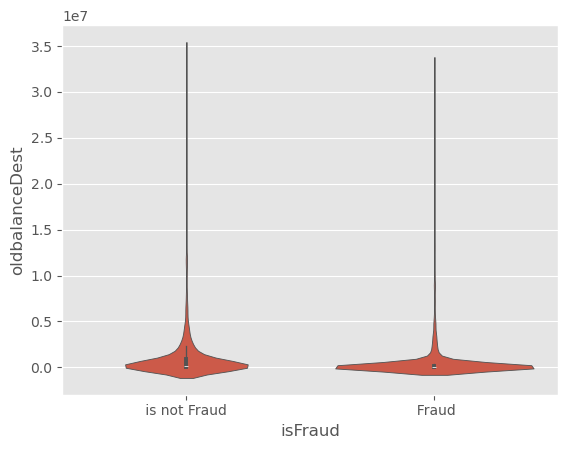

In [121]:
sns.violinplot(data = df, x='isFraud', y='oldbalanceDest')

<Axes: xlabel='isFraud', ylabel='newbalanceDest'>

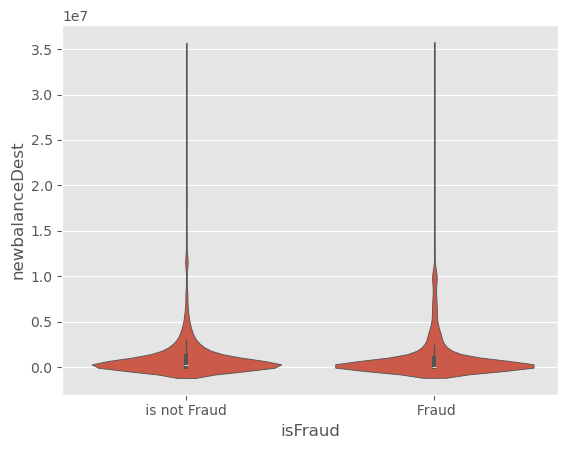

In [122]:
sns.violinplot(data = df, x='isFraud', y='newbalanceDest')

In [123]:
df.describe(include ='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
count,2430.000000,2430,2.430000e+03,2430,2.430000e+03,2.430000e+03,2430,2.430000e+03,2.430000e+03,2430
unique,NaN,5,NaN,2430,NaN,NaN,2409,NaN,NaN,2
top,NaN,CASH_OUT,NaN,C815510261,NaN,NaN,C681692677,NaN,NaN,is not Fraud
freq,NaN,1055,NaN,1,NaN,NaN,2,NaN,NaN,1288
mean,37.106996,NaN,6.428548e+05,NaN,1.067389e+06,5.189144e+05,NaN,7.416584e+05,1.106117e+06,NaN
std,24.204088,NaN,1.497136e+06,NaN,2.748249e+06,2.375727e+06,NaN,2.107973e+06,2.484056e+06,NaN
min,1.000000,NaN,7.048000e+01,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN
25%,16.250000,NaN,2.676850e+04,NaN,9.005000e+03,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN
50%,35.000000,NaN,1.464063e+05,NaN,9.669176e+04,0.000000e+00,NaN,0.000000e+00,1.293258e+05,NaN
75%,47.750000,NaN,4.346831e+05,NaN,6.669726e+05,0.000000e+00,NaN,5.106548e+05,1.088262e+06,NaN


In [124]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            2430 non-null   int64  
 1   type            2430 non-null   object 
 2   amount          2430 non-null   float64
 3   nameOrig        2430 non-null   object 
 4   oldbalanceOrg   2430 non-null   float64
 5   newbalanceOrig  2430 non-null   float64
 6   nameDest        2430 non-null   object 
 7   oldbalanceDest  2430 non-null   float64
 8   newbalanceDest  2430 non-null   float64
 9   isFraud         2430 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 190.0+ KB


<Axes: ylabel='amount'>

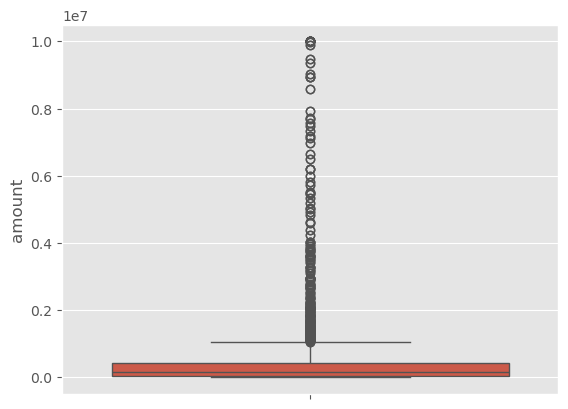

In [126]:
sns.boxplot(df['amount'])

In [127]:
from scipy import stats
print (stats.mode(df['amount']))
print (np.mean(df['amount']))

ModeResult(mode=10000000.0, count=14)
642854.8372674896


q1: 26768.5
q3: 434683.07
IQR: 407914.57
Lower Bound: -585103.355
Upper Bound: 1046554.925
Skewed data: 332
Skewed data: 0


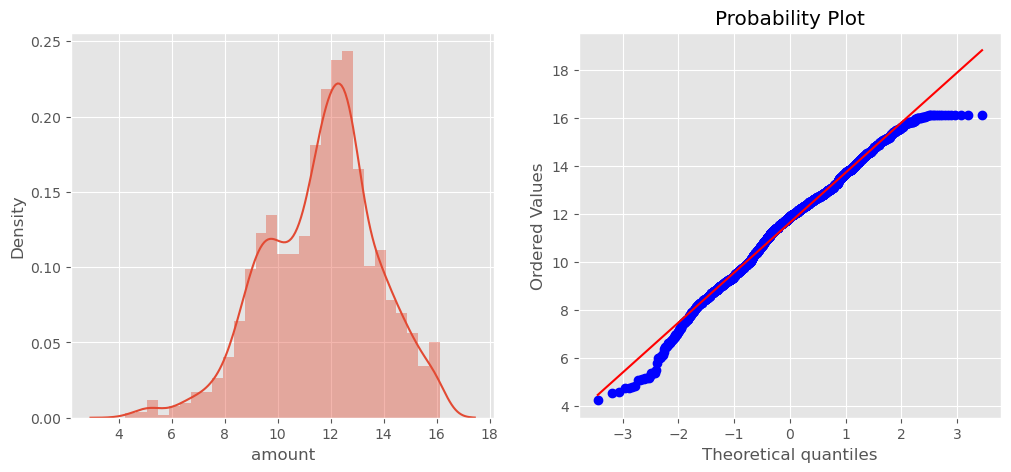

In [128]:
q1 = np.quantile(df['amount'],0.25)
q3 = np.quantile(df['amount'],0.75)

IQR = q3-q1
upper_bound = q3+(1.5*IQR)
lower_bound = q1-(1.5*IQR)

print("q1:",q1)
print("q3:",q3)
print("IQR:",IQR)
print("Lower Bound:",lower_bound)
print("Upper Bound:",upper_bound)
print("Skewed data:",len(df[df['amount']>upper_bound]))
print("Skewed data:",len(df[df['amount']<lower_bound]))

def transformationPlot(feature):
    plt.figure(figsize = (12,5))
    plt.subplot(1,2,1)
    sns.distplot(feature)
    plt.subplot(1,2,2)
    stats.probplot(feature, plot=plt)


transformationPlot(np.log(df['amount']))

df['amount'] = np.log(df['amount'])


In [129]:
df


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,10,PAYMENT,9.942455,C815510261,116.00,0.00,M1382693228,0.00,0.00,is not Fraud
1,60,CASH_OUT,10.732203,C981996349,45807.51,0.00,C1099066639,267824.05,313631.56,Fraud
2,39,PAYMENT,9.010579,C1612875324,50853.00,42663.74,M1964286640,0.00,0.00,is not Fraud
3,39,CASH_OUT,11.766732,C1711392639,0.00,0.00,C1767398596,206116.00,0.00,is not Fraud
4,77,CASH_OUT,15.558606,C1519833841,5715004.30,0.00,C1856760155,318309.23,6033313.53,Fraud
...,...,...,...,...,...,...,...,...,...,...
2425,33,CASH_OUT,15.007986,C1587398978,3295227.84,0.00,C1560573396,0.00,4002861.53,Fraud
2426,45,CASH_IN,11.407752,C1739014367,21234.00,111250.84,C1947527507,1691662.88,1601646.04,is not Fraud
2427,42,CASH_OUT,10.932450,C1284017456,10919.00,0.00,C2087603149,0.00,55963.20,is not Fraud
2428,1,CASH_OUT,12.938444,C749981943,0.00,0.00,C667346055,102.00,9291619.62,Fraud


In [130]:
df = df.drop(['nameOrig', 'nameDest'], axis=1) # removing usless data before test - train split 

In [131]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,10,PAYMENT,9.942455,116.00,0.00,0.00,0.00,is not Fraud
1,60,CASH_OUT,10.732203,45807.51,0.00,267824.05,313631.56,Fraud
2,39,PAYMENT,9.010579,50853.00,42663.74,0.00,0.00,is not Fraud
3,39,CASH_OUT,11.766732,0.00,0.00,206116.00,0.00,is not Fraud
4,77,CASH_OUT,15.558606,5715004.30,0.00,318309.23,6033313.53,Fraud
...,...,...,...,...,...,...,...,...
2425,33,CASH_OUT,15.007986,3295227.84,0.00,0.00,4002861.53,Fraud
2426,45,CASH_IN,11.407752,21234.00,111250.84,1691662.88,1601646.04,is not Fraud
2427,42,CASH_OUT,10.932450,10919.00,0.00,0.00,55963.20,is not Fraud
2428,1,CASH_OUT,12.938444,0.00,0.00,102.00,9291619.62,Fraud


---------

# **Model Training and Evaluation**

In [132]:
from sklearn.preprocessing import LabelEncoder 

la = LabelEncoder()
df['type'] = la.fit_transform(df['type'])

label_mapping = dict(zip(la.classes_, la.transform(la.classes_))) # seeing the mapping of original labels to encoded values
print("Label Mapping:")
for label, encoded in label_mapping.items():
    print(f"{label} => {encoded}")


Label Mapping:
CASH_IN => 0
CASH_OUT => 1
DEBIT => 2
PAYMENT => 3
TRANSFER => 4


In [133]:
x= df.drop('isFraud', axis = 1)
y = df['isFraud']

In [134]:
x

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,10,3,9.942455,116.00,0.00,0.00,0.00
1,60,1,10.732203,45807.51,0.00,267824.05,313631.56
2,39,3,9.010579,50853.00,42663.74,0.00,0.00
3,39,1,11.766732,0.00,0.00,206116.00,0.00
4,77,1,15.558606,5715004.30,0.00,318309.23,6033313.53
...,...,...,...,...,...,...,...
2425,33,1,15.007986,3295227.84,0.00,0.00,4002861.53
2426,45,0,11.407752,21234.00,111250.84,1691662.88,1601646.04
2427,42,1,10.932450,10919.00,0.00,0.00,55963.20
2428,1,1,12.938444,0.00,0.00,102.00,9291619.62


In [135]:
y

0        is not Fraud 
1               Fraud 
2        is not Fraud 
3        is not Fraud 
4               Fraud 
             ...      
2425            Fraud 
2426     is not Fraud 
2427     is not Fraud 
2428            Fraud 
2429     is not Fraud 
Name: isFraud, Length: 2430, dtype: object

In [136]:
from sklearn.model_selection import train_test_split

x_train,x_test, y_train, y_test = train_test_split(x,y, random_state = 0, test_size = 0.2)

print(f"x_train shape = {x_train.shape}, x_test shape = {x_test.shape}")
print(f"y_train shape = {y_train.shape}, y_test shape = {y_test.shape}")

x_train shape = (1944, 7), x_test shape = (486, 7)
y_train shape = (1944,), y_test shape = (486,)


**Random Forest**

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

y_test_predict1 = rfc.predict(x_test)
test_accuracy = accuracy_score(y_test,y_test_predict1)
test_accuracy

0.9732510288065843

In [138]:
y_train_predict1 = rfc.predict(x_train)
train_accuracy = accuracy_score(y_train,y_train_predict1)
train_accuracy

1.0

In [139]:
pd.crosstab(y_test,y_test_predict1)

col_0,Fraud,is not Fraud
isFraud,,
Fraud,215,6
is not Fraud,7,258


In [140]:
print(classification_report(y_test, y_test_predict1))

                precision    recall  f1-score   support

        Fraud        0.97      0.97      0.97       221
 is not Fraud        0.98      0.97      0.98       265

      accuracy                           0.97       486
     macro avg       0.97      0.97      0.97       486
  weighted avg       0.97      0.97      0.97       486



------------
**Decision Tree**

In [141]:
from sklearn.tree import DecisionTreeClassifier 
dct = DecisionTreeClassifier ()
dct.fit(x_train, y_train)

y_test_predict2 = dct.predict(x_test)
test_accuracy = accuracy_score(y_test,y_test_predict2)
test_accuracy

0.9382716049382716

In [142]:
y_train_predict2 = dct.predict(x_train)
train_accuracy = accuracy_score(y_train,y_train_predict2)
train_accuracy

1.0

In [143]:
pd.crosstab(y_test,y_test_predict2)

col_0,Fraud,is not Fraud
isFraud,,
Fraud,208,13
is not Fraud,17,248


In [144]:
print(classification_report(y_test, y_test_predict2))

                precision    recall  f1-score   support

        Fraud        0.92      0.94      0.93       221
 is not Fraud        0.95      0.94      0.94       265

      accuracy                           0.94       486
     macro avg       0.94      0.94      0.94       486
  weighted avg       0.94      0.94      0.94       486



--------------------
**Extra Trees Classifier**

In [145]:
from sklearn.ensemble import ExtraTreesClassifier


etc = ExtraTreesClassifier()             
etc.fit(x_train, y_train)                
y_test_predict3 = etc.predict(x_test)    
test_accuracy = accuracy_score(y_test, y_test_predict3) 
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9650


In [146]:
y_train_predict3 = etc.predict(x_train)
train_accuracy = accuracy_score(y_train,y_train_predict3)
train_accuracy

1.0

In [147]:
pd.crosstab(y_test,y_test_predict3)

col_0,Fraud,is not Fraud
isFraud,,
Fraud,210,11
is not Fraud,6,259


In [148]:
print(classification_report(y_test, y_test_predict3))

                precision    recall  f1-score   support

        Fraud        0.97      0.95      0.96       221
 is not Fraud        0.96      0.98      0.97       265

      accuracy                           0.97       486
     macro avg       0.97      0.96      0.96       486
  weighted avg       0.97      0.97      0.96       486



----------
**Support Vector Classification**

In [149]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc = SVC()

svc.fit(x_train,y_train)
y_test_predict4 = svc.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_predict4 )
test_accuracy

0.7695473251028807

In [150]:
y_train_predict4 = svc.predict(x_train)
train_accuracy = accuracy_score(y_train,y_train_predict4)
train_accuracy

0.7700617283950617

In [151]:
print(pd.crosstab(y_test,y_test_predict4))
print('\n')
print(classification_report(y_test, y_test_predict4))

col_0           Fraud   is not Fraud 
isFraud                              
 Fraud             111            110
is not Fraud         2            263


                precision    recall  f1-score   support

        Fraud        0.98      0.50      0.66       221
 is not Fraud        0.71      0.99      0.82       265

      accuracy                           0.77       486
     macro avg       0.84      0.75      0.74       486
  weighted avg       0.83      0.77      0.75       486



In [152]:
y_train1=la.fit_transform(y_train)
y_test1 = la.transform(y_test)
print('y-stest',y_test1)
print('\n')
print('y-train',y_train1)

y-stest [1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1
 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 0
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0
 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0
 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1
 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0
 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1
 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0
 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0
 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0
 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1
 1 0 0 0 1]


y-t

--------------
**XG boost**

In [153]:
import xgboost as xgb
xgb1 = xgb.XGBClassifier()
xgb1.fit(x_train, y_train1)

y_test_predict5 = xgb1.predict(x_test)
test_accuracy = accuracy_score(y_test1, y_test_predict5 )
test_accuracy

0.9835390946502057

In [169]:

input_data = np.array([[94	,1,	14.190236,	1454592.61,0.0,	264042.92	,1718635.53]])

xg_test = xgb1.predict(input_data)
print("Prediction-xg boost:", xg_test[0])

rfc_test = rfc.predict(input_data)
print("Prediction- Random forest:", rfc_test[0])

svc_test = svc.predict(input_data)
print("Prediction- SVC:", svc_test[0])


Prediction-xg boost: 0
Prediction- Random forest:   Fraud 
Prediction- SVC:   Fraud 


In [155]:
y_train_predict5 = xgb1.predict(x_train)
train_accuracy = accuracy_score(y_train1,y_train_predict5)
train_accuracy

1.0

In [156]:
print(pd.crosstab(y_test1,y_test_predict5))
print('\n')
print(classification_report(y_test1, y_test_predict5))

col_0    0    1
row_0          
0      217    4
1        4  261


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       221
           1       0.98      0.98      0.98       265

    accuracy                           0.98       486
   macro avg       0.98      0.98      0.98       486
weighted avg       0.98      0.98      0.98       486



----------------
# **Comparing Models**

In [163]:
print ('Train Accuracy for rfc', accuracy_score(y_train,y_train_predict1))
print ('Test Accuracy for rfc', accuracy_score(y_test,y_test_predict1))

print ('Train Accuracy for dtc', accuracy_score(y_train,y_train_predict2))
print ('Test Accuracy for dtc', accuracy_score(y_test,y_test_predict2))

print ('Train Accuracy for etc', accuracy_score(y_train,y_train_predict3))
print ('Test Accuracy for etc', accuracy_score(y_test,y_test_predict3))

print ('Train Accuracy for svc', accuracy_score(y_train,y_train_predict4))
print ('Test Accuracy for svc', accuracy_score(y_test,y_test_predict4))

print ('Train Accuracy for xgb1', accuracy_score(y_train1,y_train_predict5))
print ('Test Accuracy for xgb1', accuracy_score(y_test1,y_test_predict5))



Train Accuracy for rfc 1.0
Test Accuracy for rfc 0.9732510288065843
Train Accuracy for dtc 1.0
Test Accuracy for dtc 0.9382716049382716
Train Accuracy for etc 1.0
Test Accuracy for etc 0.9650205761316872
Train Accuracy for svc 0.7700617283950617
Test Accuracy for svc 0.7695473251028807
Train Accuracy for xgb1 1.0
Test Accuracy for xgb1 0.9835390946502057


In [158]:
import pickle
pickle.dump(xgb1,open("prediction.pkl",'wb')) # Saving XG boost model 

In [170]:
import pickle
pickle.dump(rfc,open("model.pkl",'wb')) # Saving RFC model 